In [3]:
import pandas as pd
import numpy as np
import time
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from string import ascii_uppercase
from numpy import random

In [2]:
db = np.loadtxt('../Frogs_MFCCs.data', delimiter = ',')
#Bufonidae - Rhinella - Rhinellagranulosa
#Dendrobatidae - Ameerega - Ameeregatrivittata
#Hylidae - 1.Dendropsophus, 2.Hypsiboas, 3.Osteocephalus, 4.Scinax - 1.HylaMinuta, 2.HypsiboasCinerascens, 2.HypsiboasCordobae, 3.OsteocephalusOophagus, 4.ScinaxRuber
#Leptodactylidae - 1.Adenomera, 2.Leptodactylus - 1.AdenomeraAndre, 1.AdenomeraHylaedactylus, 2.LeptodactylusFuscus

#Muestras
X = db[:, 0:22]

#Familias
Y = db[:, 22:25]

#Grupos
G = db[:, 25]

In [3]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

## RNA (Cross-Validation)

The best model was MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False) 

Sensibilidad: 0.9245334078822964 - Intervalo Sensibilidad: 0.08494857897808131 
Eficiencia: 0.9749861033907726 - Intervalo Eficiencia: 0.003950158533505238 
Precision: 0.9378063216635961 - Intervalo Precision: 0.06417935846512934 
F-Score: 0.9292846651079671 - Intervalo F-Score: 0.06788489530688864 
Error_Prueba: 0.025013896609227346 - Intervalo Error: 0.003950158533505252 
Tiempo ejecución: 664.2539620399475


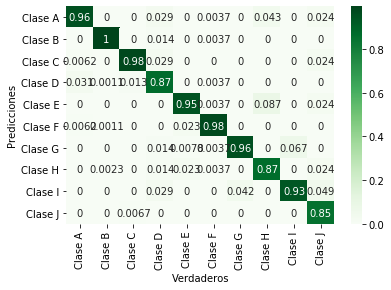

In [4]:
def RNA_model_CV(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])   
    parameters = {'hidden_layer_sizes':[x for x in itertools.product((5,10),repeat=2)]}
    RNA = MLPClassifier(activation='tanh',max_iter = 1000)
    clf = GridSearchCV(RNA, parameters)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y[:,2], test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler() #Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore
        
        #code for calculating error
        error[j] = classification_error(Yest, Ytest)
          
    if graficar == True:
        j = 0
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')

    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelRNA, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = RNA_model_CV(graficar = True)
print('The best model was', modelRNA,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

## RNA (GroupShuffleSplit)

The best model was MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=1000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False) 

Sensibilidad: 0.3552082215189653 - Intervalo Sensibilidad: 0.35115261638935186 
Eficiencia: 0.6320642474717431 - Intervalo Eficiencia: 0.0338156365285606 
Precision: 0.39673825027839443 - Intervalo Precision: 0.4012082815610987 
F-Score: 0.3162836386232042 - Intervalo F-Score: 0.3497520070691549 
Error_Prueba: 0.367935752528257 - Intervalo Error: 0.03381563652856061 
Tiempo ejecución: 8783.72166633606


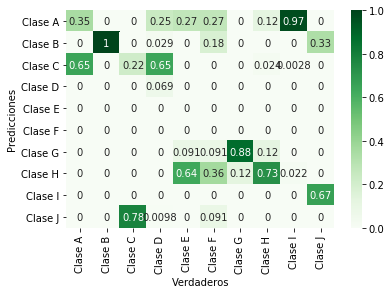

In [5]:
def RNA_model_GSS(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    parameters = {'hidden_layer_sizes':[x for x in itertools.product((5,10),repeat=2)]}
    RNA = MLPClassifier(activation='tanh',max_iter = 1000)
    group_ShuffleSplit = GroupShuffleSplit(n_splits=60, train_size=.75, random_state=42)
    clf = GridSearchCV(RNA, parameters, cv=group_ShuffleSplit.get_n_splits(X, Y[:,2], G))
    scaler = MinMaxScaler()
    scaler.fit_transform(X)
    for j in range(4):
        for train, test in group_ShuffleSplit.split(X, Y[:,2], G):
            Xtrain = X[train,:]
            Ytrain = Y[train,2]
            Xtest = X[test,:]
            Ytest = Y[test,2]
        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating error
        error[j] = classification_error(Yest, Ytest)
        
    if graficar == True:
        cm = confusion_matrix(Ytest, Yest, normalize='pred')
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')
    
    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelRNA, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = RNA_model_GSS(graficar = True)
print('The best model was', modelRNA,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)

## RNA (StratifiedKFold)

The best model was MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False) 

Sensibilidad: 0.8685930269120086 - Intervalo Sensibilidad: 0.14776678556943737 
Eficiencia: 0.9546089385474861 - Intervalo Eficiencia: 0.0028792637050402375 
Precision: 0.8998609263098162 - Intervalo Precision: 0.09675571506929087 
F-Score: 0.878591930522443 - Intervalo F-Score: 0.11027665249952688 
Error_Prueba: 0.04539106145251397 - Intervalo Error: 0.002879263705040265 
Tiempo ejecución: 1997.618024110794


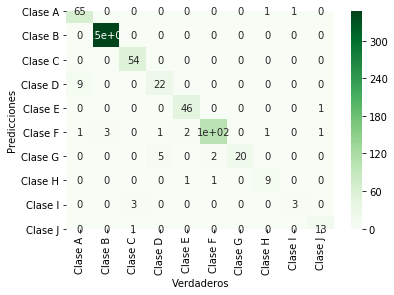

In [5]:
def RNA_model_SKF(graficar = False):
    initial_time = time.time()
    sensitivity_array = np.zeros([4,10])
    efficiency_array = np.zeros([4])
    error = np.zeros(4)
    precision_array = np.zeros([4,10])
    fscore_array = np.zeros([4,10])
    TN_array = np.zeros([4])
    FP_array = np.zeros([4])
    FN_array = np.zeros([4])
    TP_array = np.zeros([4])
    parameters = {'hidden_layer_sizes':[x for x in itertools.product((5,10),repeat=2)]}
    RNA = MLPClassifier(activation='tanh',max_iter = 1000)
    SKFold = StratifiedKFold(n_splits=10, random_state=42)
    clf = GridSearchCV(RNA, parameters, cv=SKFold.get_n_splits(X, Y[:,2]))
    scaler = MinMaxScaler()
    scaler.fit_transform(X)
    for j in range(4):
        for train, test in SKFold.split(X, Y[:,2]):
            Xtrain = X[train,:]
            Ytrain = Y[train,2]
            Xtest = X[test,:]
            Ytest = Y[test,2]
        clf.fit(Xtrain, Ytrain)
        Yest = clf.best_estimator_.predict(Xtest)

        #code for calculating recall 
        sensitivity = recall_score(Ytest, Yest, average=None)
        sensitivity_array[j] = sensitivity

        #code for calculating accuracy 
        efficiency = accuracy_score(Ytest, Yest, normalize=True)
        efficiency_array[j] = efficiency

        #code for calculating precision 
        precision = precision_score(Ytest, Yest, average=None)
        precision_array[j] = precision

        #code for calculating f1 score 
        fscore = f1_score(Ytest, Yest, average=None)
        fscore_array[j] = fscore

        #code for calculating error
        error[j] = classification_error(Yest, Ytest)
        
    if graficar == True:
        cm = confusion_matrix(Ytest, Yest)
        columnas = ['Clase %s'%(i) for i in list(ascii_uppercase)[0:len(np.unique(Yest))]]
        df_cm = pd.DataFrame(cm,index = columnas, columns = columnas)
        grafica = sns.heatmap(df_cm, cmap = 'Greens', annot = True)
        grafica.set(xlabel = 'Verdaderos', ylabel = 'Predicciones')
    
    return clf.best_estimator_, str(np.mean(sensitivity_array)), str(np.std(sensitivity_array)), str(np.mean(efficiency_array)), str(np.std(efficiency_array)), str(np.mean(precision_array)), str(np.std(precision_array)),  str(np.mean(fscore_array)), str(np.std(fscore_array)), str(np.mean(error)), str(np.std(error)), str(time.time()-initial_time)

modelRNA, sensitivity, sensitivity_interval, efficiency, efficiency_interval, precision, precision_interval, f, f_interval, error, std_error, tiempo = RNA_model_SKF(graficar = True)
print('The best model was', modelRNA,
        '\n\nSensibilidad:', sensitivity,'- Intervalo Sensibilidad:', sensitivity_interval,
        '\nEficiencia:', efficiency,'- Intervalo Eficiencia:', efficiency_interval,
        '\nPrecision:', precision,'- Intervalo Precision:', precision_interval,
        '\nF-Score:',f,'- Intervalo F-Score:', f_interval,
        '\nError_Prueba:',error,'- Intervalo Error:', std_error,
        '\nTiempo ejecución:', tiempo)